# Evolutionary Algorithm Script

This notebook is a little messy but contains the code we used to execute parameter search with evolutionary algorithms.

In [ ]:
from typing import List, Tuple
import argparse
from collections import deque

import numpy as np
import torch
import yaml
from epsilon_transformers.process.MixedStateTree import (MixedStateTree,
                                                         MixedStateTreeNode)
from epsilon_transformers.process.Process import (
    Process, _compute_emission_probabilities, _compute_next_distribution)
from epsilon_transformers.process.processes import Mess3
from tqdm import tqdm

from src.utils import get_cached_belief_filename, MODEL_PATH_005_085, MODEL_PATH_015_06
from src.generate_paths_and_beliefs import generate_mess3_beliefs, save_beliefs
from typing import Tuple, Set, List
from pathlib import Path
from transformer_lens import HookedTransformer
from src.experiment import run_activation_to_beliefs_regression, r_squared, load_model

: 

First, we create functions that can generate the ideal belief states for the sequences produced from a given HMM and then evaluate the reconstruction of these belief states from the residual stream of a given model. The reconstruction is scored using the $R^2$ of the regression. These two functions constitute the reward signal of our evolutionary search.

In [ ]:
import time

def get_beliefs(x: float, a: float):
    file_path = Path(get_cached_belief_filename(x, a))
    if file_path.exists():
        return torch.load(file_path)
    else:
        inputs, input_beliefs = generate_mess3_beliefs(x, a, sort_pairs=True)
        # save_beliefs(inputs, input_beliefs, x, a)
        return {
            "params": {"x": x, "a": a},
            "inputs": inputs,
            "input_beliefs": input_beliefs,
        }

def evaluate(model: HookedTransformer, inputs: torch.Tensor, input_beliefs: torch.Tensor):
    st = time.time()
    _, activations = model.run_with_cache(
            inputs, names_filter=lambda x: "resid_post" in x
        )
    print("activations", time.time() - st)
    acts = activations["blocks.3.hook_resid_post"].cpu().detach().numpy()
    regression, belief_predictions = run_activation_to_beliefs_regression(
        acts, input_beliefs
    )
    print("regression", time.time() - st)

    rsq = r_squared(input_beliefs, belief_predictions)

    return rsq

Initialize model and verify the above functions work (corroborated from data with scripts in `src`).

In [ ]:
p = get_beliefs(0.01, 0.9)
device = torch.device("cuda:1")
model = load_model(MODEL_PATH_005_085 / "684806400.pt", MODEL_PATH_005_085 / "train_config.json", device)
evaluate(model, p["inputs"], p["input_beliefs"])

OutOfMemoryError: CUDA out of memory. Tried to allocate 146.00 MiB. GPU 1 has a total capacity of 31.74 GiB of which 57.38 MiB is free. Process 2769872 has 31.68 GiB memory in use. Of the allocated memory 30.30 GiB is allocated by PyTorch, and 438.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Evolutionary Algorithm

We run the boilerplate evolutionary algorithm with the $R^2$ reward signal. Each new set of parameters is evaluated according to the reconstruction error of its corresponding linear probe.
- `mutation_rate` indicates the probability for each parameter that we add Gaussian random noise to it before evaluation. The noise has standard deviation equal to one-tenth the range for each parameter (`range=1.0` for `x` and `range=0.5` for alpha).
- `elitism` determines how many parameters are kept between generations.
- `crossover_rate` determines the rate at which the parameters of parents are swapped for their children.

The code below performs evolutionary search on Mess3(0.05, 0.85)

In [ ]:
import random
import numpy as np

# Define parameters
population_size = 10
generations = 5
mutation_rate = 0.5
crossover_rate = 0.7
elitism = 2

# Define ranges for x and a
x_range = (0.001, 0.5)
a_range = (0, 1)

# Fitness function
def evaluate_fitness(chromosome):
    x, a = chromosome
    belief_dict = get_beliefs(x, a)
    fitness = evaluate(model, belief_dict["inputs"], belief_dict["input_beliefs"])

    score = -torch.log(1 - fitness)

    return score

# Initialize population
def initialize_population(size):
    population = []
    for _ in range(size):
        x = random.uniform(*x_range)
        a = random.uniform(*a_range)
        population.append([x, a])
    return population

# Selection (Tournament Selection)
def select_parents(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitness)), k)
        winner = max(tournament, key=lambda ind: ind[1])[0]
        selected.append(winner)
    return selected

# Crossover (Single-Point Crossover)
def crossover(parent1, parent2):
    if random.random() < crossover_rate:
        point = random.randint(1, 1)
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        return child1, child2
    else:
        return parent1, parent2

# Mutation
def mutate(chromosome, mutation_rate, generation, max_generations):
    adjusted_mutation_rate = mutation_rate * (1 - (generation / max_generations))
    if random.random() < adjusted_mutation_rate:
        chromosome[0] = np.clip(chromosome[0] + np.random.normal(0, 0.05), *x_range)
    if random.random() < adjusted_mutation_rate:
        chromosome[1] = np.clip(chromosome[1] + np.random.normal(0, 0.1), *a_range)
    return chromosome

# Replacement (Elitism)
def replace_population(old_population, new_population, fitness, elitism_count):
    combined = list(zip(old_population, fitness)) + [(child, evaluate_fitness(child)) for child in new_population]
    combined.sort(key=lambda ind: ind[1], reverse=True)
    next_generation = [ind[0] for ind in combined[:elitism_count]]
    
    remaining = combined[elitism_count:]
    while len(next_generation) < population_size:
        candidate = remaining.pop(0)[0] if remaining else [random.uniform(*x_range), random.uniform(*a_range)]
        if not any(np.linalg.norm(np.array(candidate) - np.array(ind)) < 0.1 for ind in next_generation):
            next_generation.append(candidate)
    
    return next_generation

# Main evolutionary algorithm
def evolutionary_algorithm():
    all_generations = []
    population = initialize_population(population_size)
    for generation in range(generations):
        print(population)
        fitness = [evaluate_fitness(chromosome).item() for chromosome in population]
        
        parents = select_parents(population, fitness)
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1, mutation_rate, generation, generations), mutate(child2, mutation_rate, generation, generations)])
        
        all_generations.append((population, fitness))

        population = replace_population(population, offspring, fitness, elitism)
    
    return all_generations

# Run the algorithm and print the best solution
all_generations = evolutionary_algorithm()
#    best_solution = max(population, key=evaluate_fitness)
# print("Best solution:", best_solution)
# print("Best fitness:", evaluate_fitness(best_solution))


[[0.23065447668539504, 0.5688295806141098], [0.14630677737539072, 0.03869952689047129], [0.04526542772033849, 0.7784122092384471], [0.42018912589426355, 0.2196827570429526], [0.41766300101367254, 0.6727707286335808], [0.0246691823492879, 0.1431283012228559], [0.1165782252697695, 0.9393786452248114], [0.17804926579561753, 0.5519694446033276], [0.43612001698456165, 0.24671654220061745], [0.467961388316013, 0.2014446397540155]]
activations 0.04967021942138672
regression 0.969801664352417
activations 0.015081167221069336
regression 0.9436545372009277
activations 0.01490473747253418
regression 0.9571728706359863
activations 0.014749765396118164
regression 0.9478573799133301
activations 0.014863729476928711
regression 0.9455392360687256
activations 0.014864683151245117


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_n_coordinates(data, n, real_param, max_param=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for each tuple
    plt.figure(figsize=(10, 6))
    noise_level = 0.005  # Adjust noise level as needed

    all_coords = []
    
    for idx, (coords, z_values) in enumerate(data):
        # Convert lists to numpy arrays for easy manipulation
        coords = np.array(coords)
        z_values = np.array(z_values)
        
        # Get the indices of the top 5 z-values
        top_5_indices = np.argsort(z_values)[-n:]
        
        # Get the corresponding coordinates
        top_5_coords = coords[top_5_indices]
        
        # Collect all top 5 coordinates
        all_coords.append(top_5_coords)
    
    # Flatten the list of coordinates
    all_coords = np.vstack(all_coords)
    
    # Add noise to duplicates within and between tuples
    unique_coords, counts = np.unique(all_coords, axis=0, return_counts=True)
    for coord, count in zip(unique_coords, counts):
        if count > 1:
            duplicates = np.where((all_coords == coord).all(axis=1))[0]
            noise = np.random.normal(0, noise_level, (count, 2))
            all_coords[duplicates] += noise

    # Plot the points
    start = 0
    for idx, (coords, z_values) in enumerate(data):
        num_points = len(np.argsort(z_values)[-n:])
        top_5_coords = all_coords[start:start + num_points]
        start += num_points
        
        plt.scatter(top_5_coords[:, 0], top_5_coords[:, 1], color=colors[idx % len(colors)], label=f'Generation {idx+1}')
    
    # Plot real_param if provided
    if real_param is not None:
        plt.scatter(real_param[0], real_param[1], color='black', marker='x', s=100, label='Real Param')

    # Plot max_param if provided
    if max_param is not None:
        plt.scatter(max_param[0], max_param[1], color='black', marker='o', s=100, label='Param with max R^2')

    plt.xlim(0, 0.55)
    plt.ylim(0, 1.1)
    plt.xlabel('x')
    plt.ylabel('alpha')
    plt.title(f'Top {n} coordinates in each generation by R^2 for Mess3({real_param[0]},{real_param[1]})')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig(f"evo_alg_{str(real_param).replace('.','')}.jpg")


Evolutionary algorithm for Mess3(0.15, 0.6)

In [ ]:
import random
import numpy as np

# Define parameters
population_size = 10
generations = 5
mutation_rate = 0.5
crossover_rate = 0.7
elitism = 2
model_015_06 = load_model(MODEL_PATH_015_06 / "998406400.pt", MODEL_PATH_015_06 / "train_config.json", device)

# Define ranges for x and a
x_range = (0.001, 0.5)
a_range = (0, 1)

# Fitness function
def evaluate_fitness(chromosome):
    x, a = chromosome
    belief_dict = get_beliefs(x, a)
    fitness = evaluate(model_015_06, belief_dict["inputs"], belief_dict["input_beliefs"])

    score = -torch.log(1 - fitness)

    return score

# Initialize population
def initialize_population(size):
    population = []
    for _ in range(size):
        x = random.uniform(*x_range)
        a = random.uniform(*a_range)
        population.append([x, a])
    return population

# Selection (Tournament Selection)
def select_parents(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitness)), k)
        winner = max(tournament, key=lambda ind: ind[1])[0]
        selected.append(winner)
    return selected

# Crossover (Single-Point Crossover)
def crossover(parent1, parent2):
    if random.random() < crossover_rate:
        point = random.randint(1, 1)
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        return child1, child2
    else:
        return parent1, parent2

# Mutation
def mutate(chromosome, mutation_rate, generation, max_generations):
    adjusted_mutation_rate = mutation_rate * (1 - (generation / max_generations))
    if random.random() < adjusted_mutation_rate:
        chromosome[0] = np.clip(chromosome[0] + np.random.normal(0, 0.05), *x_range)
    if random.random() < adjusted_mutation_rate:
        chromosome[1] = np.clip(chromosome[1] + np.random.normal(0, 0.1), *a_range)
    return chromosome

# Replacement (Elitism)
def replace_population(old_population, new_population, fitness, elitism_count):
    combined = list(zip(old_population, fitness)) + [(child, evaluate_fitness(child)) for child in new_population]
    combined.sort(key=lambda ind: ind[1], reverse=True)
    next_generation = [ind[0] for ind in combined[:elitism_count]]
    
    remaining = combined[elitism_count:]
    while len(next_generation) < population_size:
        candidate = remaining.pop(0)[0] if remaining else [random.uniform(*x_range), random.uniform(*a_range)]
        if not any(np.linalg.norm(np.array(candidate) - np.array(ind)) < 0.1 for ind in next_generation):
            next_generation.append(candidate)
    
    return next_generation

# Main evolutionary algorithm
def evolutionary_algorithm():
    all_generations = []
    population = initialize_population(population_size)
    for generation in range(generations):
        print(population)
        fitness = [evaluate_fitness(chromosome).item() for chromosome in population]
        
        parents = select_parents(population, fitness)
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1, mutation_rate, generation, generations), mutate(child2, mutation_rate, generation, generations)])
        
        all_generations.append((population, fitness))

        population = replace_population(population, offspring, fitness, elitism)
    
    return all_generations

# Run the algorithm and print the best solution
all_generations_015_06 = evolutionary_algorithm()
#    best_solution = max(population, key=evaluate_fitness)
# print("Best solution:", best_solution)
# print("Best fitness:", evaluate_fitness(best_solution))


[[0.0746913781060409, 0.37397790088106386], [0.2307926007249338, 0.3817757729962421], [0.2939170966815935, 0.976807554139024], [0.3799214358487325, 0.3884841516530566], [0.3514254903709265, 0.09639246833539084], [0.020801718624776814, 0.8631982049423038], [0.1648178925193035, 0.6679533560212526], [0.08827224065776051, 0.10136254454283322], [0.2282388372522952, 0.7072116502306052], [0.3075882694816705, 0.031012213820161283]]
[[0.1648178925193035, 0.6679533560212526], [0.1648178925193035, 0.6679533560212526], [0.1648178925193035, 0.370324969645837], [0.24012333082997653, 0.4968085397958634], [0.2642546988424461, 0.9266208142271322], [0.30144545177719667, 0.40937215787667336], [0.3356787188699642, 1.0], [0.3075882694816705, 0.031012213820161283], [0.08827224065776051, 0.10136254454283322], [0.020801718624776814, 0.8631982049423038]]
[[0.1430065991822183, 0.6679533560212526], [0.16305931775072732, 0.6679533560212526], [0.1648178925193035, 0.40937215787667336], [0.24012333082997653, 0.49680

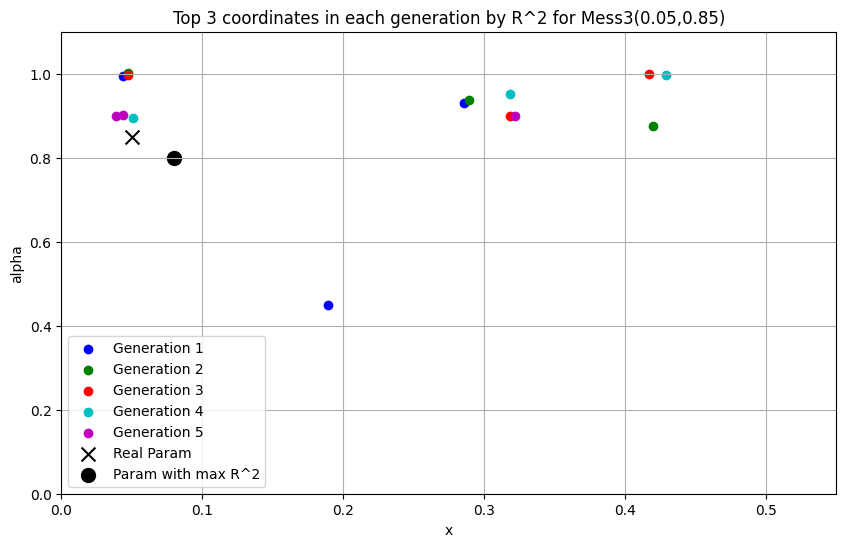

In [ ]:
plot_top_n_coordinates(all_generations, 3, (0.05, 0.85), (0.08, 0.8))

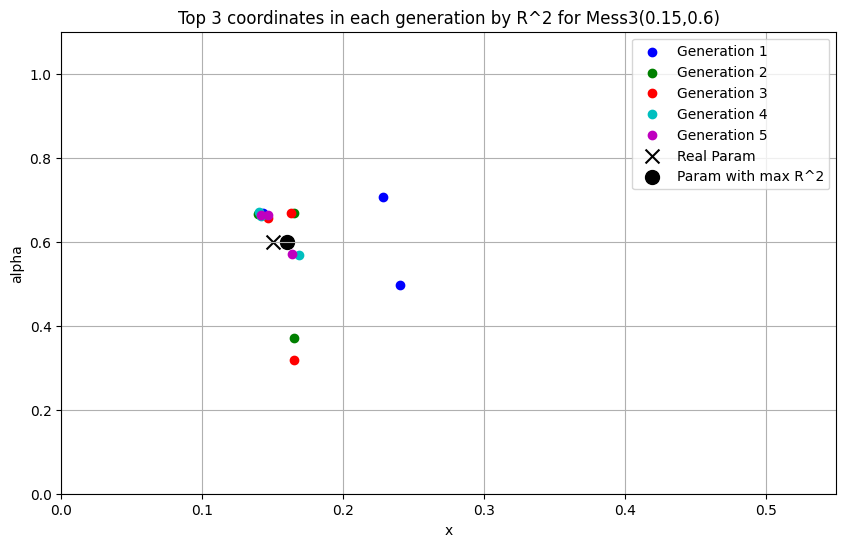

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_top_n_coordinates(all_generations_015_06, 3, (0.15, 0.6), (0.16, 0.6))

### Messy code to evaluate R-squared (ignore)

In [ ]:
import math
max_r2 = 0
max_point = []
max_gen = 0
for gen_idx, (points, fitnesses) in enumerate(all_generations_015_06):
    for i in range(len(points)):
        if 1 - math.exp(-fitnesses[i]) > max_r2:
            max_r2 = 1 - math.exp(-fitnesses[i])
            max_point = points[i]
            max_gen = gen_idx + 1
print(max_point, max_r2, max_gen)

[0.1430065991822183, 0.6679533560212526] 0.9991014001751073 3


In [ ]:
points = [max_point, [0.15, 0.6], [0.16, 0.6]]

for x, a in points:
    belief_dict = get_beliefs(x, a)
    print(x, a, evaluate(model_015_06, belief_dict["inputs"], belief_dict["input_beliefs"]))

0.1430065991822183 0.6679533560212526 tensor(0.9991)
0.15 0.6 tensor(0.9992, dtype=torch.float64)
0.16 0.6 tensor(0.9992)


In [ ]:
import math
max_r2 = 0
max_point = []
max_gen = 0
for gen_idx, (points, fitnesses) in enumerate(all_generations):
    for i in range(len(points)):
        if 1 - math.exp(-fitnesses[i]) > max_r2:
            max_r2 = 1 - math.exp(-fitnesses[i])
            max_point = points[i]
            max_gen = gen_idx + 1
print(max_point, max_r2, max_gen)

[0.08872948475926701, 0.40416504542988047] 0.9939424398381217 1


In [ ]:
points = [max_point, [0.05, 0.85], [0.08, 0.8]]

for x, a in points:
    belief_dict = get_beliefs(x, a)
    print(x, a, evaluate(model, belief_dict["inputs"], belief_dict["input_beliefs"]))

0.08872948475926701 0.40416504542988047 tensor(0.9706)
0.05 0.85 tensor(0.9966, dtype=torch.float64)
0.08 0.8 tensor(0.9984)
